In [1]:
# Import libraries
import warnings
warnings.filterwarnings("ignore")
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, roc_curve, auc
import SimpleITK as sitk
import six
from radiomics import featureextractor 
import numpy as np
import os
import pickle
import pandas as pd
import logging
from scipy.stats import linregress
from sklearn.linear_model import QuantileRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RANSACRegressor
import os
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
import warnings
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
from sklearn.exceptions import ConvergenceWarning
from sklearn import preprocessing as skp
from sklearn import model_selection as sms
from sklearn import feature_selection as skf
from sklearn import linear_model as slm
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util as util
from train import train_estimator
import nibabel as nib
import os
import pickle
from torch import nn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (15,5)
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0]//2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()
    

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index-1) % volume.shape[0] 
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index+1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

In [3]:
# Set window level
level = 0
window = 500
m1=level-window/2
m2=level+window/2
visualize = 1
# Load data
nrows = 256
ncols = 256
nslices = 160
segs = []
qsms = []
laros = []
voxel_sizes = []
trackers = []
q_directory = '/data/Ali/RadDBS-QSM/data/nii/chh/orig/qsm/'
q_directory = os.listdir(q_directory)
q_directory = sorted(q_directory)
qu_directory = '/data/Ali/RadDBS-QSM/data/nii/chh/lr_roi_ft'
qu_directory = os.listdir(qu_directory)
qu_directory = sorted(qu_directory)
s_directory = '/data/Ali/RadDBS-QSM/data/nii/chh/orig/seg/'
s_directory = os.listdir(s_directory)
s_directory = sorted(s_directory)
m_directory = '/data/Ali/RadDBS-QSM/data/nii/chh/masks'
m_directory = os.listdir(m_directory)
m_directory = sorted(m_directory)
case_list = []
d_count = 0
if visualize == 1:
    for filename in q_directory:
    
        seg_filename = s_directory[d_count]
        laro_filename = qu_directory[d_count]
        mask_filename = m_directory[d_count]
        seg = nib.load('/data/Ali/RadDBS-QSM/data/nii/chh/orig/seg/'+seg_filename)
        mask = nib.load('/data/Ali/RadDBS-QSM/data/nii/chh/masks/'+mask_filename)
        voxel_size = seg.header['pixdim'][0:3]
        voxel_sizes.append(voxel_size)
        segs.append(seg.get_fdata()[:nrows,:ncols,:nslices])
        qsm = nib.load('/data/Ali//RadDBS-QSM/data/nii/chh/orig/qsm/'+filename)
        qsms.append(qsm.get_fdata()[:nrows,:ncols,:nslices])

        laro = nib.load('/data/Ali/RadDBS-QSM/data/nii/chh/lr_roi_ft/'+laro_filename)
        laros.append(1000*laro.get_fdata()[:nrows,:ncols,:nslices])
        print('Appending arrays with segmentation',seg_filename,'QSM,',filename,
              'LARO,',laro_filename,'and mask',mask_filename)
        case_list.append(filename)
        n_cases = len(segs)
        d_count = d_count+1




Appending arrays with segmentation 01_roi_combined.nii QSM, 00001_qsm.nii.gz LARO, QSM_lrr_01.nii and mask mask01.nii
Appending arrays with segmentation 02_roi_combined.nii QSM, 00002_qsm.nii.gz LARO, QSM_lrr_02.nii and mask mask02.nii
Appending arrays with segmentation 03_roi_combined.nii QSM, 00003_qsm.nii.gz LARO, QSM_lrr_03.nii and mask mask03.nii
Appending arrays with segmentation 04_roi_combined.nii QSM, 00004_qsm.nii.gz LARO, QSM_lrr_04.nii and mask mask04.nii
Appending arrays with segmentation 05_roi_combined.nii QSM, 00005_qsm.nii.gz LARO, QSM_lrr_05.nii and mask mask05.nii
Appending arrays with segmentation 06_roi_combined.nii QSM, 00006_qsm.nii.gz LARO, QSM_lrr_06.nii and mask mask06.nii
Appending arrays with segmentation 07_roi_combined.nii QSM, 00007_qsm.nii.gz LARO, QSM_lrr_07.nii and mask mask07.nii
Appending arrays with segmentation 08_roi_combined.nii QSM, 00008_qsm.nii.gz LARO, QSM_lrr_08.nii and mask mask08.nii
Appending arrays with segmentation 09_roi_combined.nii Q

In [4]:
df = pd.read_csv('/data/Ali/RadDBS-QSM/data/xlxs/updrs_iii_chh_cvs.csv')
df

,subjects,LCT,Unnamed: 2,UPDRSⅢ,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,NaN,NaN,NaN,Preoperative Off-Medicine,Preoperative On-Medicine,Postoperative Off-Medicine &Off-Stimulation\n,Postoperative Off-Medicine &On-Stimulation,Postoperative On-Medicine &On-Stimulation,age,"Gender(male=0,female=1)",Disease duration(years),LEDD
1,1.0,62.26%,NaN,53,20,40,15,7,66,1,9,825
2,2.0,75.00%,NaN,32,8,26,17,10,64,1,6,856.25
3,3.0,51.72%,NaN,58,28,52,18,20,67,1,15,1350
4,4.0,22.58%,NaN,62,48,61,36,28,69,1,5,350
5,5.0,55.88%,NaN,34,15,44,29,22,63,1,10,751.25
6,6.0,75.44%,NaN,57,14,55,32,16,67,1,5,525
7,7.0,84.00%,NaN,100,16,68,12,NaN,58,0,10,1087.5
8,8.0,41.86%,NaN,43,25,48,26,26,74,1,10,550
9,9.0,72.58%,NaN,62,17,56,25,11,57,1,10,500


In [5]:
# Patient IDs
subject_id = np.asarray(df[df.columns[0]])[1:]

# Only extract ROI if it is present in all cases
seg_labels_all = segs[0]
case_number = np.zeros_like(np.asarray(s_directory))
for i in range(n_cases):
    case_number[i] = float(s_directory[i][:2])
subject_id_corr = subject_id[np.in1d(subject_id,case_number)]
age = np.nan_to_num(np.asarray(df[df.columns[-4]])[1:][np.in1d(subject_id,case_number)].astype(float))
sex = np.nan_to_num(np.asarray(df[df.columns[-3]])[1:][np.in1d(subject_id,case_number)].astype(float))
dd = np.nan_to_num(np.asarray(df[df.columns[-2]])[1:][np.in1d(subject_id,case_number)].astype(float))
ledd = np.nan_to_num(np.asarray(df[df.columns[-1]])[1:][np.in1d(subject_id,case_number)].astype(float))

for i in np.arange(n_cases):
    try:
        print('Found ROIs',str(np.unique(segs[i])),'at segmentation directory file',s_directory[i],'for case',str(subject_id_corr[i]))
    except:
        print('Case',subject_id[i],'quarantined')


Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 01_roi_combined.nii for case 1.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 02_roi_combined.nii for case 2.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 03_roi_combined.nii for case 3.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 04_roi_combined.nii for case 4.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 05_roi_combined.nii for case 5.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 06_roi_combined.nii for case 6.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 07_roi_combined.nii for case 7.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 08_roi_combined.nii for case 8.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 09_roi_combined.nii for case 9.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 10_roi_combined.nii for case 10.0
Found ROIs [0. 1. 2

In [6]:
pre_updrs_iii_off =  np.asarray(df[df.columns[3]][np.hstack((False,np.in1d(subject_id,subject_id_corr)))])                                
pre_updrs_iii_on =  np.asarray(df[df.columns[4]][np.hstack((False,np.in1d(subject_id,subject_id_corr)))])
post_updrs_iii_off =  np.asarray(df[df.columns[6]][np.hstack((False,np.in1d(subject_id,subject_id_corr)))])

per_change = (np.asarray(pre_updrs_iii_off).astype(float)-np.asarray(post_updrs_iii_off).astype(float))/(np.asarray(pre_updrs_iii_off).astype(float))
lct_change = (np.asarray(pre_updrs_iii_off).astype(float)-(np.asarray(pre_updrs_iii_on)).astype(float))/(np.asarray(pre_updrs_iii_off).astype(float))

In [7]:
logger = logging.getLogger("radiomics")
logger.setLevel(logging.ERROR)

reextract = 0

# Assume all voxel sizes are identical
voxel_size = (0.9,0.9,0.9)
if reextract == 1:
    # Generate feature structure Phi from all ROIs and all cases
    extractor = featureextractor.RadiomicsFeatureExtractor()
    extractor.enableAllFeatures()
    extractor.enableAllImageTypes()
    extractor.enableFeatureClassByName('shape2D',enabled = False)

    seg_labels_all = np.unique(np.asarray(segs))
    Phi_gt = []
    Phi_vd = []
    Phi_lr = []
    seg_labels = []
    reextract = 0
    x_row_gt = []
    x_row_lr = []

    keylib = []
    roilib = []
    loop_count = 1
    n_rois = seg_labels_all[seg_labels_all>0].__len__()
    roi_names = np.asarray(['Background','Right substantia nigra','Right subthalamic nucleus',
                            'Left subthalamic nucleus', 'Left substantia nigra', 'Right dentate nucleus', 'Left dentate nucleus'])
    for i in np.arange(subject_id_corr.__len__()):
        seg_sitk = sitk.GetImageFromArray(segs[i])
        seg_sitk.SetSpacing(voxel_size)
        qsm_sitk_gt = sitk.GetImageFromArray(qsms[i])
        qsm_sitk_gt.SetSpacing(voxel_size)
        qsm_sitk_lr = sitk.GetImageFromArray(laros[i])
        qsm_sitk_lr.SetSpacing(voxel_size)
        # Index back since subject 12 is missing ROIs
        for j in seg_labels_all:
            if j>0:
                fv_count = 0
                featureVector_gt = extractor.execute(qsm_sitk_gt,seg_sitk,label=int(j));
                featureVector_lr = extractor.execute(qsm_sitk_lr,seg_sitk,label=int(j));
                Phi_gt.append(featureVector_gt)
                Phi_lr.append(featureVector_lr)
                for key, value in six.iteritems(featureVector_gt):
                    if 'diagnostic' in key:
                        next
                    else:
                        x_row_gt.append(featureVector_gt[key])
                        x_row_lr.append(featureVector_lr[key])
                        fv_count = fv_count+1
                        keylib.append(key)
                        roilib.append(roi_names[int(j)])
                x_row_gt.append(pre_updrs_iii_off[i])
                x_row_lr.append(pre_updrs_iii_off[i])
                fv_count = fv_count+1
        print('Extracting features for subject',subject_id_corr[i],'and appending feature matrix with vector of length',fv_count,'with UPDRS score',pre_updrs_iii_off[i])
                
    X0_gt = np.array(x_row_gt)
    X0_lr = np.array(x_row_lr)
    np.save('/data/Ali/RadDBS-QSM/data/npy/rp/X0_gt_chh_rois_rp.npy',X0_gt)
    np.save('/data/Ali/RadDBS-QSM/data/npy/rp/X0_lr_chh_rois_rp.npy',X0_lr)

    K = np.asarray(keylib)
    R = np.asarray(roi_names)
    np.save('/data/Ali/RadDBS-QSM/data/npy/rp/K_chh_rp.npy',K)
    np.save('/data/Ali/RadDBS-QSM/data/npy/rp/R_chh_rp.npy',R)

    print('Saving ground truth feature vector')
    with open('/data/Ali/RadDBS-QSM/data/npy/rp/Phi_mcl_gt_roi_chh_rp', 'wb') as fp:  
        pickle.dump(Phi_gt, fp)
    
    print('Saving undersampled feature vector')
    with open('/data/Ali/RadDBS-QSM/data/npy/rp/Phi_mcl_lr_roi_chh_rp', 'wb') as fp:  
        pickle.dump(Phi_lr, fp)

else:
    X0_gt = np.load('/data/Ali/RadDBS-QSM/data/npy/rp/X0_gt_chh_rois_rp.npy')
    X0_lr = np.load('/data/Ali/RadDBS-QSM/data/npy/rp/X0_lr_chh_rois_rp.npy')
    K = np.load('/data/Ali/RadDBS-QSM/data/npy/rp/K_chh_rp.npy')
    R = np.load('/data/Ali/RadDBS-QSM/data/npy/rp/R_chh_rp.npy')
    n_rois = R.shape[0]-1
    with open('/data/Ali/RadDBS-QSM/data/npy/rp/Phi_mcl_gt_roi_chh_rp', "rb") as fp:  
        Phi_gt = pickle.load(fp)
    
    with open('/data/Ali/RadDBS-QSM/data/npy/rp/Phi_mcl_lr_roi_chh_rp', "rb") as fp:  
        Phi_lr = pickle.load(fp)

    

In [8]:
n_features = 1596
n_rois = 6
X_all_c = X0_gt.reshape(n_cases,n_rois,n_features)[:,0:4,:]
K_all_c = K.reshape(n_cases,n_rois,n_features-1)[:,0:4,:]
K_all_c = np.char.add(K_all_c[0,:,:].reshape(-1,1),' ')
R_all_c = np.repeat(R[1:5],n_features-1)
K_all_c = np.char.add(np.squeeze(K_all_c),np.squeeze(R_all_c))
K_all_c = np.append(K_all_c,['pre updrs']*5)
R_all_c = np.append(R_all_c,['pre updrs']*5)
K_all_c = np.append(K_all_c,['age'])
R_all_c = np.append(R_all_c,['age'])
K_all_c = np.append(K_all_c,['disease duration'])
R_all_c = np.append(R_all_c,['disease duration'])
K_all_c = np.append(K_all_c,['sex'])
R_all_c = np.append(R_all_c,['sex'])
K_all_c = np.append(K_all_c,['ledd'])
R_all_c = np.append(R_all_c,['ledd'])

In [9]:
n_cases = len(per_change)
n_roisc = Phi_gt.__len__()/n_cases
L = int(len(X0_gt)/n_cases)
n_features = int(L/n_rois)
subsc = subject_id_corr
pre_updrs_off = pre_updrs_iii_off
results_ls_aug = np.zeros_like(per_change)

results_lgr_aug = np.zeros_like(per_change)
results_lgrp_aug = np.zeros_like(per_change)
results_ls = np.zeros_like(per_change)
results_lgr = np.zeros_like(per_change)
results_lgrp = np.zeros_like(per_change)
r = 1

In [10]:
os.environ['PYTHONWARNINGS']='ignore'
warnings.filterwarnings("ignore")
ns = 6
results_ls_aug = np.zeros((ns-1,len(per_change)))
results_ls_wbs = np.zeros((ns-1,len(per_change)))
results_ls_smogn = np.zeros((ns-1,len(per_change)))

In [18]:
retrain = 0
for j in np.arange(ns-1):
    if retrain == 1:
        #results_ls_aug[j,:] = train_estimator(subsc,X_all_c,K_all_c,per_change,pre_updrs_iii_on,age,sex,dd,ledd,'nc',True,True,j,True)
        results_ls_wbs[j,:] = train_estimator(subsc,X_all_c,K_all_c,per_change,pre_updrs_iii_on,age,sex,dd,ledd,'wbs',True,True,j,True)
        #results_ls_smogn[j,:] = train_estimator(subsc,X_all_c,K_all_c,per_change,pre_updrs_iii_on,age,sex,dd,ledd,'smogn',True,True,j,True)
    else:
        results_ls_smogn[j,:] = np.load('results_ls_smogn_'+str(j)+'_cvs_puo.npy')
        results_ls_aug[j,:] = np.load('results_ls_nc_'+str(j)+'_cvs_puo.npy')
        results_ls_wbs[j,:] = np.load('results_ls_wbs_'+str(j)+'_cvs_puo.npy')

In [19]:
from util import confidence_interval

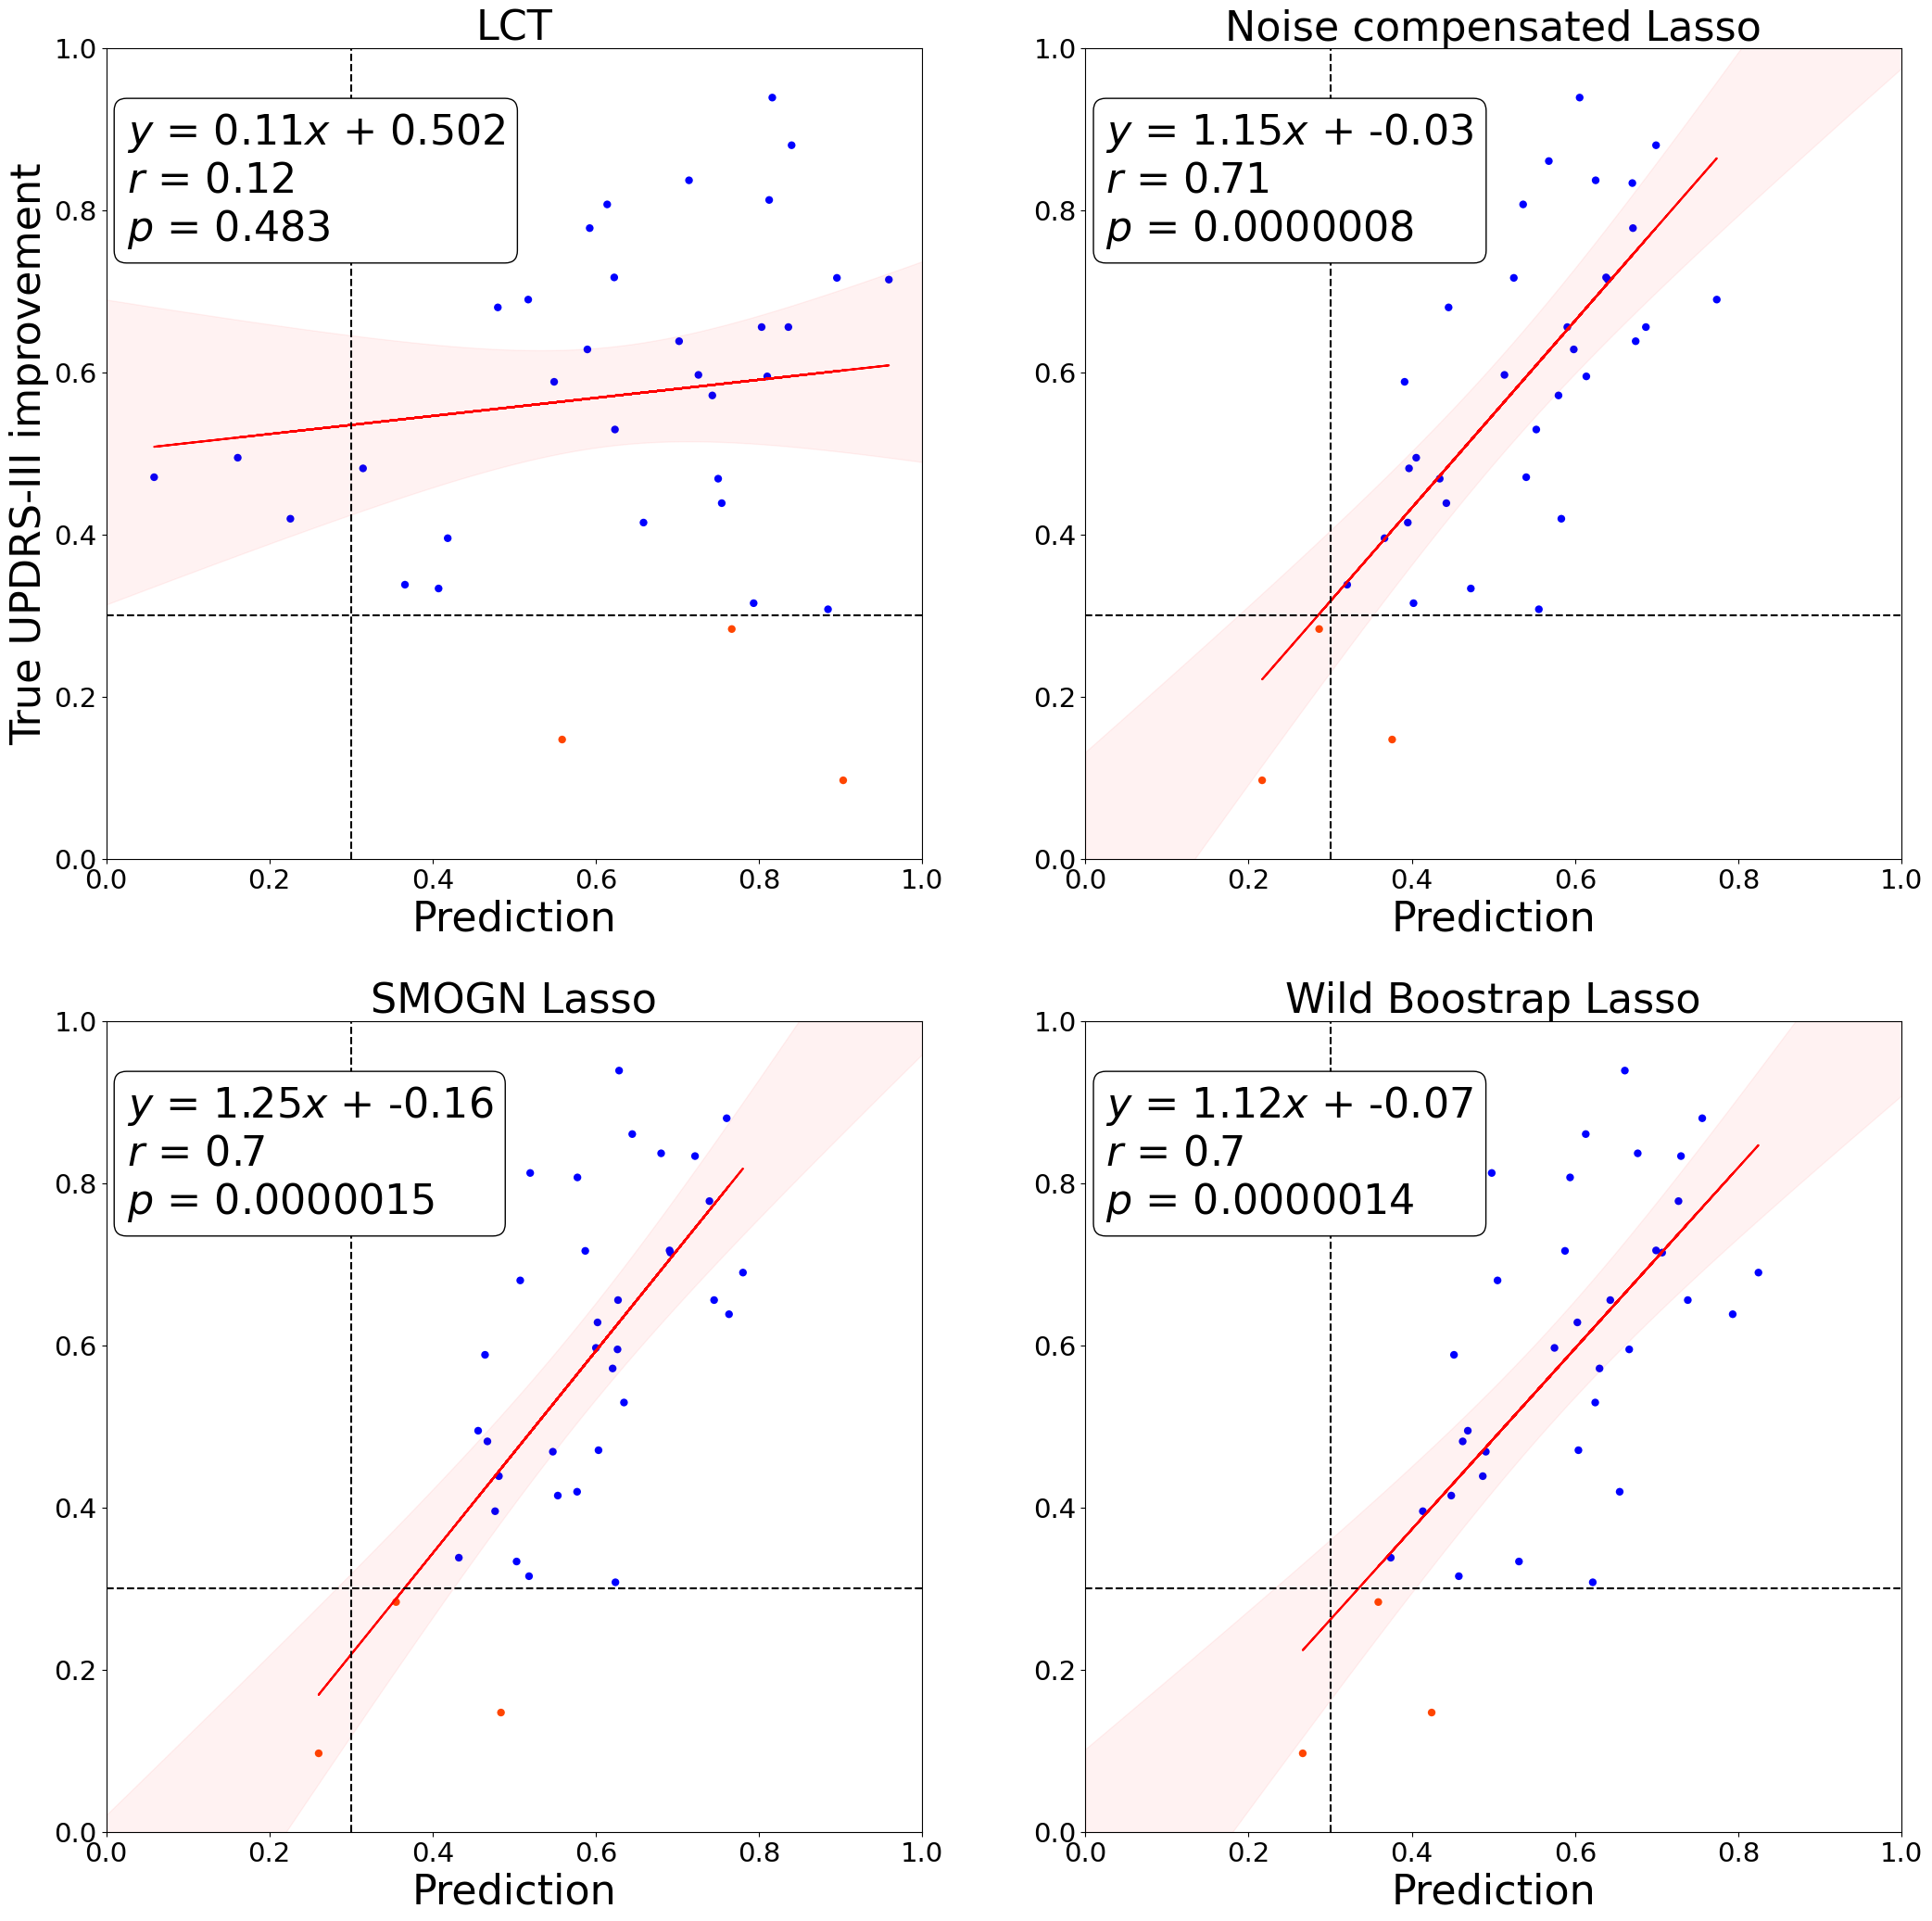

In [20]:
ylim = 1.25
fs = 32
ofx = 0.025
ofy = 0.75
pre_imp = (np.asarray(pre_updrs_iii_off,dtype=float)-np.asarray(pre_updrs_iii_on,dtype=float))/np.asarray(pre_updrs_iii_off,dtype=float)
plt.rcParams['figure.figsize'] = [25, 25]
fig,ax = plt.subplots(2,2,sharex=True,sharey=True)
col = np.where(per_change <= 0.3,'orangered','blue')
ax[0,0].scatter(pre_imp,per_change, c=col,linewidth=0)
lr = stats.linregress(pre_imp,per_change)
y_model = pre_imp*lr.slope+lr.intercept
ax[0,0].plot(pre_imp,y_model,color='r')
ci,pi,x_line,y_line = util.confidence_interval(pre_imp,per_change)
ax[0,0].fill_between(x_line, (y_line+ci), (y_line-ci), color='r', alpha=0.05)
ax[0,0].text(ofx,ofy,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,3))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.3f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[0,0].transAxes,fontsize=fs,
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round')) 
ax[0,0].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[0,0].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[0,0].set_title('LCT',fontsize=fs)
ax[0,0].set_xlabel('Prediction',fontsize=fs)
ax[0,0].xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[0,0].set_xlim([0,1])
ax[0,0].set_ylabel('True UPDRS-III improvement',fontsize=fs)
ax[0,0].yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[0,0].set_ylim([0,1])

ax[0,1].scatter(np.mean(results_ls_aug,axis=0),per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(np.mean(results_ls_aug,axis=0)),per_change)
y_model = np.mean(results_ls_aug,axis=0)*lr.slope+lr.intercept
ax[0,1].plot(np.mean(results_ls_aug,axis=0),y_model,color='r')
ci,pi,x_line,y_line = util.confidence_interval(np.mean(results_ls_aug,axis=0),per_change)
ax[0,1].fill_between(x_line,y_line+ci,y_line-ci,color = 'r',label = '95% confidence interval',alpha=0.05)
ax[0,1].text(ofx,ofy,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.7f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[0,1].transAxes,fontsize=fs,
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round')) 
ax[0,1].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[0,1].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[0,1].set_title('Noise compensated Lasso',fontsize=fs)
ax[0,1].set_xlabel('Prediction',fontsize=fs)
ax[0,1].xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[0,1].yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)

ax[1,0].scatter(np.mean(results_ls_smogn,axis=0),per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(np.mean(results_ls_smogn,axis=0)),per_change)
y_model = np.mean(results_ls_smogn,axis=0)*lr.slope+lr.intercept
ax[1,0].plot(np.mean(results_ls_smogn,axis=0),y_model,color='r')
ci,pi,x_line,y_line = util.confidence_interval(np.mean(results_ls_smogn,axis=0),per_change)
ax[1,0].fill_between(x_line,y_line+ci,y_line-ci,color = 'r',label = '95% confidence interval',alpha=0.05)
ax[1,0].text(ofx,ofy,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.7f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[1,0].transAxes,fontsize=fs,
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round')) 
ax[1,0].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[1,0].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[1,0].set_xlabel('Prediction',fontsize=fs)
ax[1,0].xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
# ax[2].set_ylabel('True Improvement',fontsize=fs)
ax[1,0].yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[1,0].set_title('SMOGN Lasso',fontsize=fs)

ax[1,1].scatter(np.mean(results_ls_wbs,axis=0),per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(np.mean(results_ls_wbs,axis=0)),per_change)
y_model = np.mean(results_ls_wbs,axis=0)*lr.slope+lr.intercept
ax[1,1].plot(np.mean(results_ls_wbs,axis=0),y_model,color='r')
ci,pi,x_line,y_line = util.confidence_interval(np.mean(results_ls_wbs,axis=0),per_change)
ax[1,1].fill_between(x_line,y_line+ci,y_line-ci,color = 'r',label = '95% confidence interval',alpha=0.05)
ax[1,1].text(ofx,ofy,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.7f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[1,1].transAxes,fontsize=fs,
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round')) 
ax[1,1].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[1,1].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[1,1].set_xlabel('Prediction',fontsize=fs)
ax[1,1].xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[1,1].yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[1,1].set_title('Wild Boostrap Lasso',fontsize=fs)

plt.style.use('default')

In [21]:
# from collections import Counter

# plt.rcParams["figure.figsize"] = (30,15)
# fig, axes = plt.subplots(1,4,sharey=True)
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.2, 
#                     hspace=0.2)

# R = [item for sublist in K_nz_vl for item in sublist]
# letter_counts = Counter(R)
# lc = { x: count for x, count in letter_counts.items() if count > 35 } #30
# df = pd.DataFrame.from_dict(lc, orient='index')
# df.sort_values(0, ascending=False, inplace=True)
# df.plot(ax=axes[0], y=0, kind='bar', legend=False, fontsize=fs,stacked=True, width=1, edgecolor='black',color='tab:orange')
# axes[0].set_title('Lasso',fontsize=fs)
# R = [item for sublist in K_nz_smogn for item in sublist]
# letter_counts = Counter(R)
# lc = { x: count for x, count in letter_counts.items() if count > 35 } #23
# df = pd.DataFrame.from_dict(lc, orient='index')
# df.sort_values(0, ascending=False, inplace=True)
# df.plot(ax=axes[1], y=0, kind='bar', legend=False, fontsize=fs,stacked=True, width=1, edgecolor='black',color='tab:red')
# axes[1].set_title('SMOGN Lasso',fontsize=fs)
# R = [item for sublist in K_nz_wbs for item in sublist]
# letter_counts = Counter(R)
# lc = { x: count for x, count in letter_counts.items() if count > 35 } #28
# df = pd.DataFrame.from_dict(lc, orient='index')
# df.sort_values(0, ascending=False, inplace=True)
# df.plot(ax=axes[2], y=0, kind='bar', legend=False, fontsize=fs,stacked=True, width=1, edgecolor='black',color='tab:purple')
# axes[2].set_title('Wild Bootstrap Lasso',fontsize=fs)
# R = [item for sublist in K_nz_nc for item in sublist]
# letter_counts = Counter(R)
# lc = { x: count for x, count in letter_counts.items() if count > 35 } #25
# df = pd.DataFrame.from_dict(lc, orient='index')
# df.sort_values(0, ascending=False, inplace=True)
# df.plot(ax=axes[3], y=0, kind='bar', legend=False, fontsize=fs,stacked=True, width=1, edgecolor='black',color='tab:green')
# axes[3].set_title('Noise Compensated Lasso',fontsize=fs)
# plt.suptitle('Predictive radiomic features',fontsize=fs)
# plt.ylabel('Frequency',fontsize=16)

# plt.style.use('default')

In [22]:
from sklearn.metrics import precision_recall_curve, recall_score, accuracy_score, precision_score

In [24]:
# plt.rcParams["figure.figsize"] = (10,5)
# fig,ax = plt.subplots(1,1,sharex=True,sharey=True)
# t = 0.3
# y_bin = per_change<t

# # y_predicted_ls = 1-results_ls
# # y_predicted_ls_aug = 1-results_ls_aug
# # y_predicted_lct = 1-pre_imp
# # y_predicted_aug = 1-results_lgrp_aug
# # y_predicted_lr = 1-results_lgrp
# # y_predicted_smogn = 1-results_ls_smogn
# # y_predicted_wbs = 1-results_ls_wbs

# estimators = np.vstack((lct_change < 0.3,results_lgr,results_lgr_aug,results_ls < 0.3,results_ls_aug < 0.3,results_ls_smogn < 0.3,results_ls_wbs < 0.3))


# # # fprlsa, tprlsa, _ = roc_curve(y_bin,  y_predicted_ls_aug)
# # # fprls, tprls, _ = roc_curve(y_bin,  y_predicted_ls)
# # # fprl, tprl, _ = roc_curve(y_bin,  y_predicted_lct)
# # fpra, tpra, ts_aug = roc_curve(y_bin, y_predicted_aug)
# # pra,rca,ta = precision_recall_curve(y_bin,y_predicted_aug)
# # fprlr, tprlr, ts = roc_curve(y_bin, y_predicted_lr)
# # prlr,rclr,tlr = precision_recall_curve(y_bin,y_predicted_lr)
# # fprl = np.zeros_like(fprlr)
# # tprl = np.zeros_like(tprlr)
# scores = np.zeros((7,4))

# for j in np.arange(estimators.shape[0]):
#     spf = recall_score(y_bin,estimators[j,:],pos_label=0)
#     scores[j,0] = spf
#     sns = recall_score(y_bin,estimators[j,:])
#     scores[j,1] = sns
#     acc = accuracy_score(y_bin,estimators[j,:])
#     scores[j,2] = acc
#     prec = precision_score(y_bin,estimators[j,:])
#     scores[j,3] = prec

# # fprlss, tprlss, _ = roc_curve(y_bin, y_predicted_smogn)
# # fprlwb, tprlwb, _ = roc_curve(y_bin, y_predicted_wbs)
# # print(fprl)
# # print(tprl)
# # # roc_auc_lct = auc(fprl, tprl)
# # roc_auc_lr = auc(fprlr, tprlr)
# # roc_auc_lr_aug = auc(fpra, tpra)
# # roc_auc_ls = auc(fprls, tprls)
# # roc_auc_ls_aug = auc(fprlsa, tprlsa)
# # roc_auc_ls_smogn = auc(fprlss, tprlss)
# # roc_auc_ls_wbs = auc(fprlwb, tprlwb)

# # plt.rcParams['legend.loc']='lower right'
# ax.plot(np.asarray((0,1,2,3)),np.squeeze(scores[0,:]), '-o', label = 'LCT',color='tab:blue')
# ax.plot(np.asarray((0,1,2,3)),np.squeeze(scores[3,:]), '-o', label = 'Lasso',color='tab:orange',zorder=7)
# ax.plot(np.asarray((0,1,2,3)),np.squeeze(scores[5,:]), '-o', label = 'SMOGN Lasso',color='tab:red')
# ax.plot(np.asarray((0,1,2,3)),np.squeeze(scores[6,:]), '-o', label = 'Wild Bootstrap Lasso',color='tab:purple',zorder=6)
# ax.plot(np.asarray((0,1,2,3)),np.squeeze(scores[4,:]), '-o', label = 'Noise Compensated Lasso',color='tab:green')
# ax.plot(np.asarray((0,1,2,3)),np.squeeze(scores[1,:]), '-o', label = 'Logistic Regression',color='tab:gray')
# ax.plot(np.asarray((0,1,2,3)),np.squeeze(scores[2,:]), '-o', label = 'Noise Compensated Logistic regression',color='tab:pink')
# ax.set_xticks((0,1,2,3))
# ax.set_xticklabels(['Specificity','Sensitivity','Accuracy','Precision'])
# ax.set_ylim((-0.15,1.15))
# # ax[0].plot(fprlr, tprlr, label = 'LR AUC = %0.2f' % roc_auc_lr, linewidth=5)
# # ax[0].plot(fpra, tpra, label = 'LR + noise AUC = %0.2f' % roc_auc_lr_aug, linewidth=5)
# # ax[0].plot(np.linspace(0,1,len(fpra)),np.linspace(0,1,len(fpra)),linewidth=5,color='black',linestyle='dashed')
# # ax[0].set_title('Receiver Operating Characteristic',fontsize=fs)
# # ax[0].set_xlabel('False positive rate \n $(1-specificity$)',fontsize=fs)
# # ax[0].set_ylabel('True positive rate \n $(sensitivity$)',fontsize=fs)
# # ax[0].xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
# # ax[0].yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
# ax.legend(bbox_to_anchor=(1,0.25),fontsize=fs//3)

# plt.rcParams['legend.loc']='lower left'
# plt.title('Classification performance')
# # ax[1].plot(rclr, prlr, linewidth=5)
# # ax[1].plot(rca, pra, linewidth=5)
# # # ax[1].plot(fprlsa, tprlsa, label = 'Lasso + noise AUC = %0.2f' % roc_auc_ls_aug, linewidth=5)
# # # ax[1].plot(fprlss, tprlss, label = 'Lasso + SMOGN AUC = %0.2f' % roc_auc_ls_smogn, linewidth=5)
# # # ax[1].plot(fprlwb, tprlwb, label = 'Lasso + wild bootstrap AUC = %0.2f' % roc_auc_ls_wbs, linewidth=5)
# # ax[1].set_title('Precision Recall',fontsize=fs)
# # ax[1].set_xlabel('Recall \n $(sensitivity$)',fontsize=fs)
# # ax[1].set_ylabel('Precision \n $(sensitivity$)',fontsize=fs)
# # ax[1].xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
# # ax[1].yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
# # ax[1].legend(fontsize=fs//1.5)
# # plt.style.use('default')
# # plt.show()

In [ ]:
scores

In [ ]:
np.asarray((0,1,2)).shape

In [ ]:
np.squeeze(scores[j,0]).shape